In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from seispy.station.stationdata import SeismometerArray
from seispy.station import homestake
from scipy.linalg import pinv2,svd
from numpy.linalg import inv
plt.style.use('stylesheet.mplstyle')
from scipy.io import savemat
import astropy.units as u
import numpy as np
import os
os.environ['PROJ_LIB'] = '/home/patrick.meyers/anaconda3/envs/meyers/share/proj'
import seispy.plot as hplot
import healpy as hp

In [2]:
 # parameters for injections
amplitude = 1 # UNITS? m? dimensionless? other?
freq = 1 # Hz
duration=100
nside=8
fftlength = 100
# set up array
stations=homestake(origin='TPK')

In [3]:
print(stations['DEAD'])

[3500.3748630000046, 4707.410118999891, 0]


In [4]:
######
# SETUP
######
# initialize data with 0s
data = SeismometerArray.initialize_all_good(stations, duration, chans_type='fast_chans')
# get station names
snames = data.keys()
# get p-waves
data.add_r_wave(amplitude, np.radians(30), np.radians(90),freq, duration, velocity=2500, phase=90)
data.add_p_wave(amplitude, np.radians(330), np.radians(120),freq,duration=duration, c=5700)#, v=3000)
data.add_s_wave(amplitude, np.radians(30), np.radians(60),0,freq,duration=duration,c=4000)#, v=3000)

	using default eigenfunction


In [5]:
Ys2 = data.get_coherences(freq, fft_duration=fftlength) / fftlength**2 # make units m^2, for easy comparison to injected amplitudes

2628


100%|██████████| 24/24 [00:00<00:00, 24.67it/s]


In [6]:
thetas = np.array([np.pi / 2.])
phis = np.arange(0.5,360,1)*np.pi / 180.
Gr,shapes = data.get_gamma_matrix_nonhealpy('r',stations,2500,freq,
                                                            thetas=thetas,
                                                            phis=phis)
Gp,shapes = data.get_gamma_matrix_healpy('p',stations,5700,freq, nside=nside)
# S-waves come out stacked Sh, then Sv, which we note here, and then
# use below when unpacking things
Gs,shapes = data.get_gamma_matrix_healpy('s',stations,4000,freq, nside=nside)
G = np.vstack((Gr,Gp,Gs)).T
# G = np.vstack((Gr,Gp)).T

In [7]:
Fisher = np.dot(G.T.conj(),G)
u, s, vh = svd(Fisher, full_matrices=False, check_finite=False)

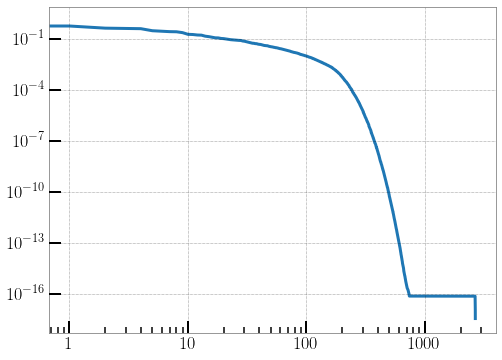

In [8]:
# Plot singular values
plt.plot(s/max(s))
plt.yscale('log')
plt.xscale('log')
plt.show()

In [9]:
# construct pseudo-inverse by hand
# useful to do it this way so we don't have
# to keep re-running SVD whenever we change s_min
mycond=1e-3
rank = np.sum(s > mycond * np.max(s))
psigma_diag = 1.0 / s[: rank]
invFisher = np.transpose(np.conjugate(np.dot(u[:, : rank] *
                                         psigma_diag, vh[: rank])))

In [10]:
# do inversion
S = np.real(np.dot(invFisher, np.dot(G.T.conj(), Ys2)))
print(np.sum(S))

4.09341698752


In [11]:
# Unpack
npix = hp.nside2npix(nside)
S_r = S[:phis.size]
S_p = S[phis.size:npix+phis.size]
# Sh comes before Sv
S_sh = S[npix+phis.size:2*npix+phis.size]
S_sv = S[2*npix+phis.size:]
max_swaves = max(max(np.abs(S_sh)), max(np.abs(S_sv)))

In [12]:
# Print total map power in each mode
print(np.sum(S_r))
print(np.sum(S_p))
print(np.sum(S_sh))
print(np.sum(S_sv))

0.854446923266
1.21516957708
2.48468084672
-0.460880359543


0.854446923266
1.21516957708


/home/patrick.meyers/anaconda3/envs/seismic_work/lib/python3.9/site-packages/matplotlib/projections/geo.py:394: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))
/home/patrick.meyers/git_repos/seismic_radiometer/seispy/plot.py:496: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdBu_r").copy()
  aximg.cmap.set_bad('w', alpha=0.)


2.48468084672
-0.460880359543


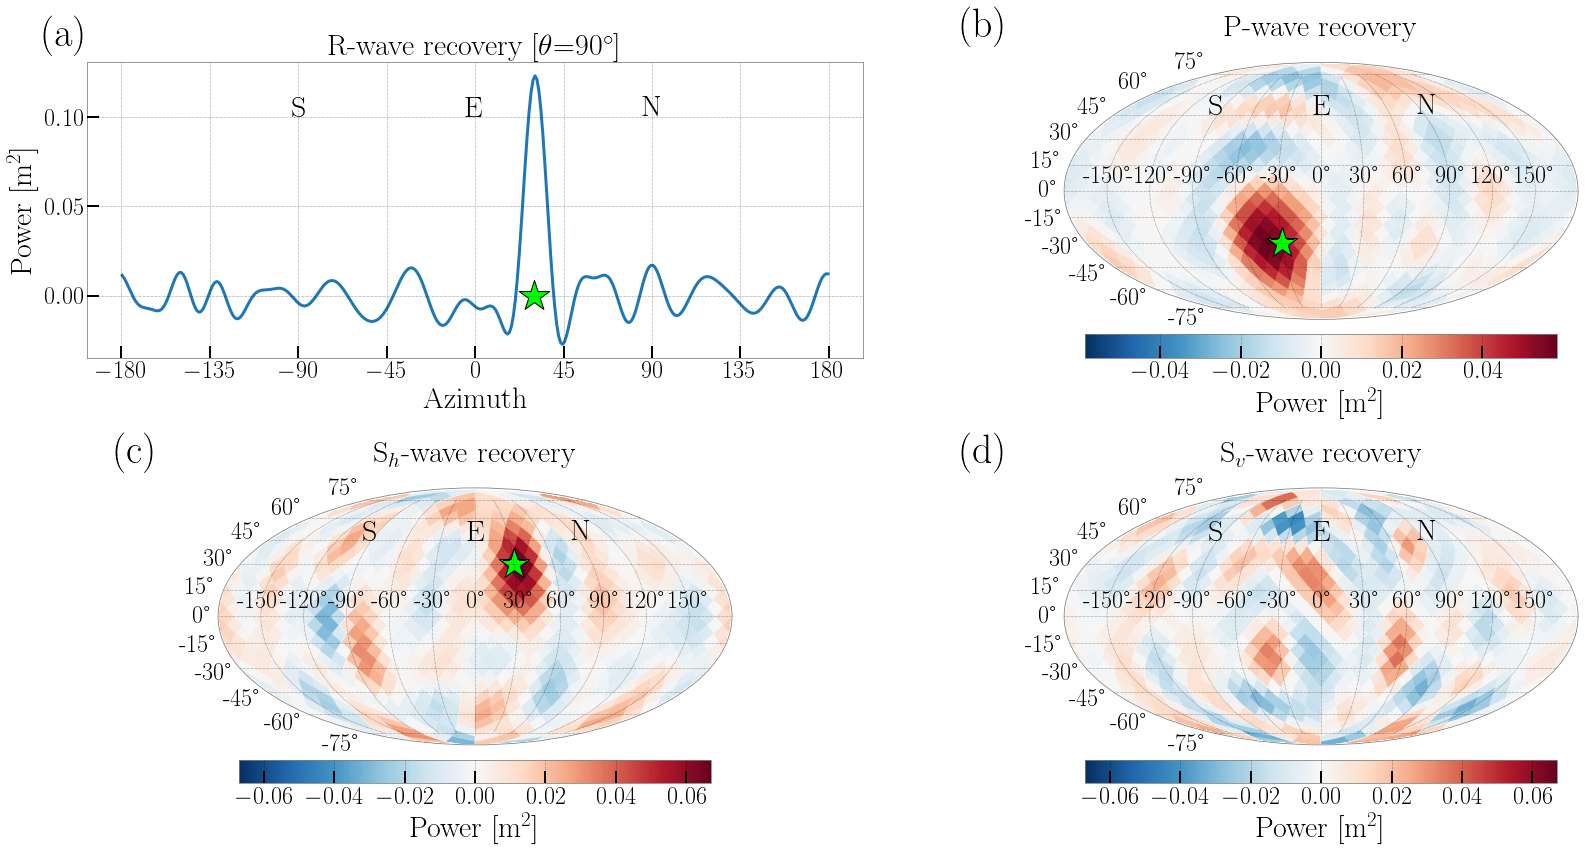

In [13]:
strs=['p','sh','sv']
labelstrs = ['(b)', '(c)', '(d)']
nsides=[nside,nside,nside]
# S_full = np.real(np.dot(G_inv, np.real(np.dot(G.T.conj(), Y))))
last = 0
# Keep scale the same for both maps
# use this variable to do it.
phis[phis>np.pi] = phis[phis>np.pi] - 2*np.pi
args = np.argsort(phis)
maxS = 0
plt.figure(figsize=(24,12))
ax = plt.subplot(221)
ax.plot(np.degrees(phis[args]), S_r[args])
ax.set_title(r'R-wave recovery [$\theta$=90$^\circ$]',fontsize=30)
ax.tick_params(labelsize=24)
ax = plt.gca()
# ax.set_ylim(-1e-2, 2e-2)
ax.scatter([30], [0], marker='*', s=1024, c='lime', edgecolor='k')
ax.text(0-5,0.1,'E', fontsize=30)
ax.text(90-5,0.1,'N', fontsize=30)
# ax.text(180-6,6e-10,'W', fontsize=30)
ax.text(-90-3,0.1,'S', fontsize=30)

ax.set_xlabel(r'Azimuth', fontsize=30)
ax.set_xticks([-180,-135,-90,-45,0,45,90,135,180])
ax.set_ylabel(r'Power [m$^2$]',fontsize=30)

ax.text(-220, 0.14, '(a)', fontsize=40)

print(np.sum(S_r))
for ii,string in enumerate(strs):
    num=int('22'+str(ii+2))
    npix = hp.pixelfunc.nside2npix(nsides[ii])
    ax = plt.subplot(num, projection='mollweide')
    if string=='p':
        S_full = S_p
        ax.set_title(r'P-wave recovery',y=1.08, fontsize=30)
    elif string=='sh':
        S_full = S_sh
        ax.set_title(r'S$_h$-wave recovery',y=1.08, fontsize=30)
    elif string=='sv':
        S_full = S_sv
        ax.set_title(r'S$_v$-wave recovery',y=1.08, fontsize=30)
    last += npix
    S = np.real(S_full.copy())
    print(np.sum(S_full))
    maxS = np.abs(S).max()
    ax.annotate(labelstrs[ii], (-0.2, 1.1), xycoords='axes fraction', fontsize=40)

    #print S

    if string == 'sh' or string=='sv':
        hplot.healpix_heatmap(S, cmap='RdBu_r', vmin=-max_swaves, vmax=max_swaves)#, vmin=-.02, vmax=.02, rasterized=True)#, norm=matplotlib.colors.LogNorm())
    else:
        hplot.healpix_heatmap(S, cmap='RdBu_r', vmin=-maxS, vmax=maxS)
    # hplot.outline_text(ax)
    ax.grid(True)

    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(24)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(24)
    maxs = hp.pixelfunc.pix2ang(nsides[ii],np.argmax(S))
    h = plt.colorbar(orientation='horizontal', pad=0.05, fraction=0.08)
    h.ax.set_xlabel('Power [m$^2$]', fontsize=30)

    for tick in h.ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(24)
    if string=='p':
        ax.scatter(np.radians([-30]),np.radians([-30]), marker='*',s=1024, c='lime', rasterized=True, edgecolor='k')
#         hplot.healpix_contour(S, [contour_val], colors='k', width=20, linestyle='--', rasterized=True, linewidths=2, linestyles='--')
    if string=='sh':
        ax.scatter(np.radians([30]),np.radians([30]), marker='*',s=1024, c='lime', rasterized=True, edgecolor='k')
#         hplot.healpix_contour(S, [contour_val], colors='k', width=20, linestyle='--', rasterized=True, linewidths=2, linestyles='--')
    # plt.title('Total power in contour: %4.2e m$^2$, map: %4.2e m$^2$' % (S_sorted[S_cdf < 0.95].sum(),S_sorted.sum()),
    #               y=1.08,fontsize=20)
    ax.text(np.radians(-7),np.radians(45),'E', fontsize=30)
    ax.text(np.radians(90-7),np.radians(45),'N', fontsize=30)
    # ax.text(np.radians(180-5),np.radians(60),'W', fontsize=20)
    ax.text(np.radians(-90-7),np.radians(45),'S', fontsize=30)
plt.tight_layout()
plt.savefig('r_and_p_s_inj_all_rec.pdf', format='pdf')
plt.show()
